||||||||||||||||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
||||||<h1>Jupiter Objects with Python</h1>||||<img src="https://articolidiastronomia.com/wp-content/uploads/2020/08/cropped-orologio-solare.jpg" alt="articolidiastronomia logo" style="height:50px; width:50px;"/>|| [articolidiastronomia.com](attachment:./articolidiastronomia.com) </br> Alessandro Fumagalli|||<img src="https://articolidiastronomia.com/wp-content/uploads/2021/01/licenza.png" alt="licenza" style="height:25px; width:120px;"/>||

In [56]:
#!pip3 install folium
#!pip3 install geopy
#!pip3 install astropy
#!pip3 install rebound

### Import the modules needed for processing

In [1]:
import pandas as pd
import seaborn as sns

### Read MPC file with orbital data
- Data downloaded from https://cgi.minorplanetcenter.net/data

In [4]:
df = pd.read_csv("data/mpcorb_extended.csv", low_memory=False)
pd.set_option("display.max_columns", None)
df.head()

,H,G,Num_obs,rms,U,Arc_years,Perturbers,Perturbers_2,Number,Name,Principal_desig,Other_desigs,Epoch,M,Peri,Node,i,e,n,a,Ref,Num_opps,Computer,Hex_flags,Last_obs,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type,NEO_flag,One_km_NEO_flag,PHA_flag,Critical_list_numbered_object_flag,One_opposition_object_flag,Arc_length
0,3.32,0.15,7259.0,0.65,0,1801-2022,M-v,30l,(1),Ceres,A801 AA,"['A899 OF', '1943 XB']",2459800.5,334.32723,73.53158,80.26642,10.58680,0.078636,0.214181,2.766619,E2022-SB7,123,MPCLINUX,0000,2022-09-16,2.459920e+06,4.601761,2.549064,2.984174,1.374756,1.277642,MBA,NaN,NaN,NaN,NaN,NaN,NaN
1,4.12,0.15,8871.0,0.59,0,1804-2022,M-c,28k,(2),Pallas,A802 FA,NaN,2459800.5,315.09111,310.84262,172.91791,34.92715,0.229986,0.213851,2.769463,MPO710565,120,MPCLINUX,0000,2022-08-04,2.460011e+06,4.608859,2.132524,3.406402,1.311488,1.277096,MBA,NaN,NaN,NaN,NaN,NaN,NaN
2,5.14,0.15,7411.0,0.63,0,1804-2022,M-v,3El,(3),Juno,A804 RA,NaN,2459800.5,306.62242,247.80396,169.84591,12.99223,0.256775,0.225857,2.670422,E2022-U28,113,MPCLINUX,0000,2022-10-16,2.460037e+06,4.363851,1.984725,3.356120,1.247176,1.297278,MBA,NaN,NaN,NaN,NaN,NaN,NaN
3,3.20,0.15,7508.0,0.63,0,1821-2022,M-p,18l,(4),Vesta,A807 FA,NaN,2459800.5,61.19232,151.25772,103.80084,7.14078,0.088402,0.271511,2.361987,E2022-T39,108,MPCLINUX,0000,2022-09-23,2.459575e+06,3.630081,2.153183,2.570791,1.171764,1.380216,MBA,NaN,NaN,NaN,NaN,NaN,NaN
4,7.02,0.15,3099.0,0.72,0,1845-2022,M-v,3El,(5),Astraea,A845 XA,['1969 SE'],2459800.5,208.56769,358.79230,141.56759,5.36542,0.188985,0.238175,2.577540,E2022-U63,85,MPCLINUX,0000,2022-10-13,2.460436e+06,4.138168,2.090423,3.064657,1.242741,1.318657,MBA,NaN,NaN,NaN,NaN,NaN,NaN


### Show the size of dataframe in terms of numbers of records found

In [5]:
df.dropna()
df.shape

(1243630, 38)

### Pre processing
- Removed useless columns 
- Renamed orbit type
- List all different orbit types

In [6]:
#removed useless fields and rename others
df.drop(['NEO_flag','Critical_list_numbered_object_flag','One_opposition_object_flag'], axis=1, inplace=True)
df.drop(['One_km_NEO_flag','Computer','Number','U','PHA_flag', 'Hex_flags'], axis=1, inplace=True)
df.drop(['Ref','Arc_length','Tp','Num_opps','Perturbers_2','Perturbers','n'], axis=1, inplace=True)
df.rename(columns={"Perihelion_dist": "q", "Aphelion_dist": "Q"}, inplace=True)
df["Orbit_type"].replace({"Object with perihelion distance < 1.665 AU": "q < 1.665 AU"}, inplace=True)
df["Orbit_type"].replace({"Jupiter Trojan": "Trojan"}, inplace=True)
df.Orbit_type.unique()

array(['MBA', 'Phocaea', 'q < 1.665 AU', 'Hilda', 'Amor', 'Hungaria',
       'Trojan', 'Apollo', 'Distant Object', 'Aten', 'Atira'],
      dtype=object)

### Filter on the following object types:

- Object type $\in$ {Hilda, Trojan, Hungaria}
- Object with $\sigma$ < 10

In [7]:
MPC_Jupyter_H = df.apply(lambda r: r[df['Orbit_type'].isin(['Hungaria','Hilda','Trojan'])])
MPC_Jupyter_no_outliers = MPC_Jupyter_H[MPC_Jupyter_H['H'] < (10 * MPC_Jupyter_H['H'].std())] 

### Distribution of objects per types

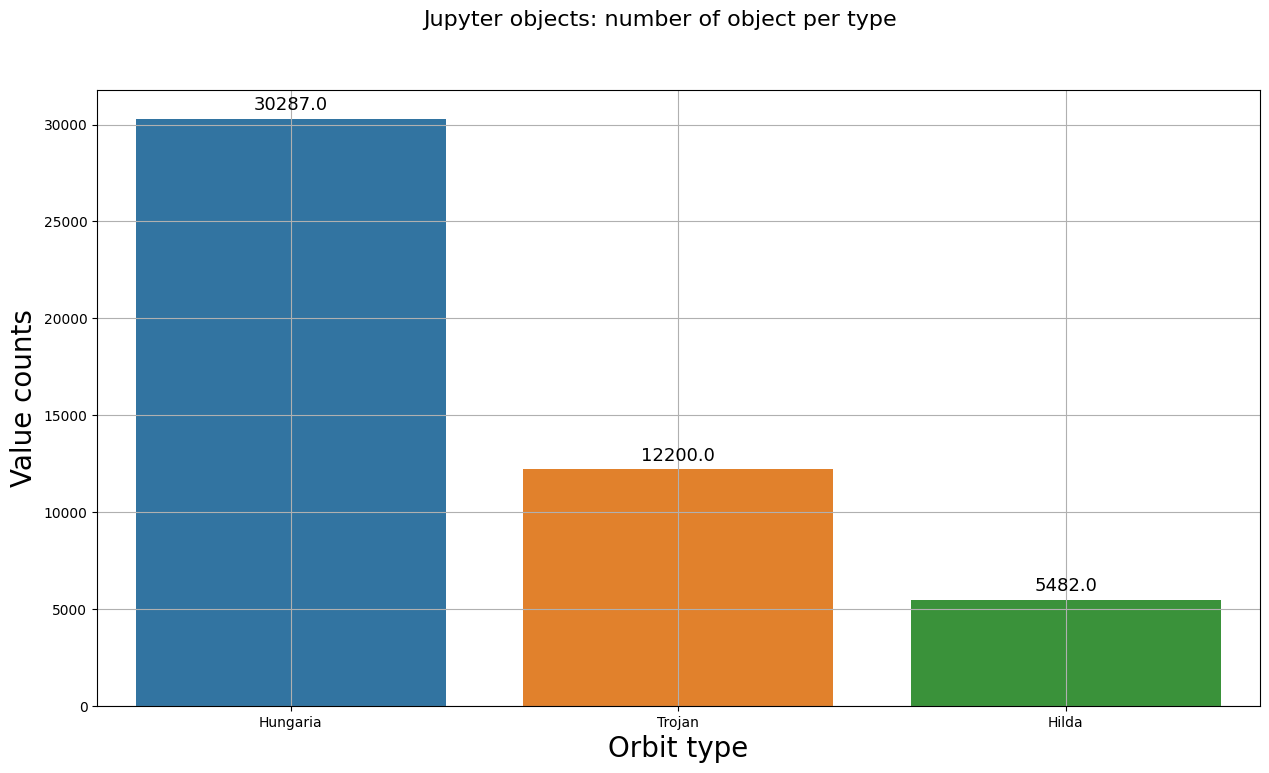

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
splot=sns.countplot(x="Orbit_type", data=MPC_Jupyter_no_outliers, order = MPC_Jupyter_no_outliers['Orbit_type'].value_counts().index)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=13, xytext = (0, +10), textcoords = 'offset points')
plt.grid()
plt.suptitle('Jupyter objects: number of object per type', fontsize=16)
plt.xlabel("Orbit type", size=20)
plt.ylabel("Value counts", size=20)

plt.savefig('figure/jupyter_objects_distribution.png', dpi=600)

### Scatter diagrams

- *a* vs *e*
- *a* vs *i*

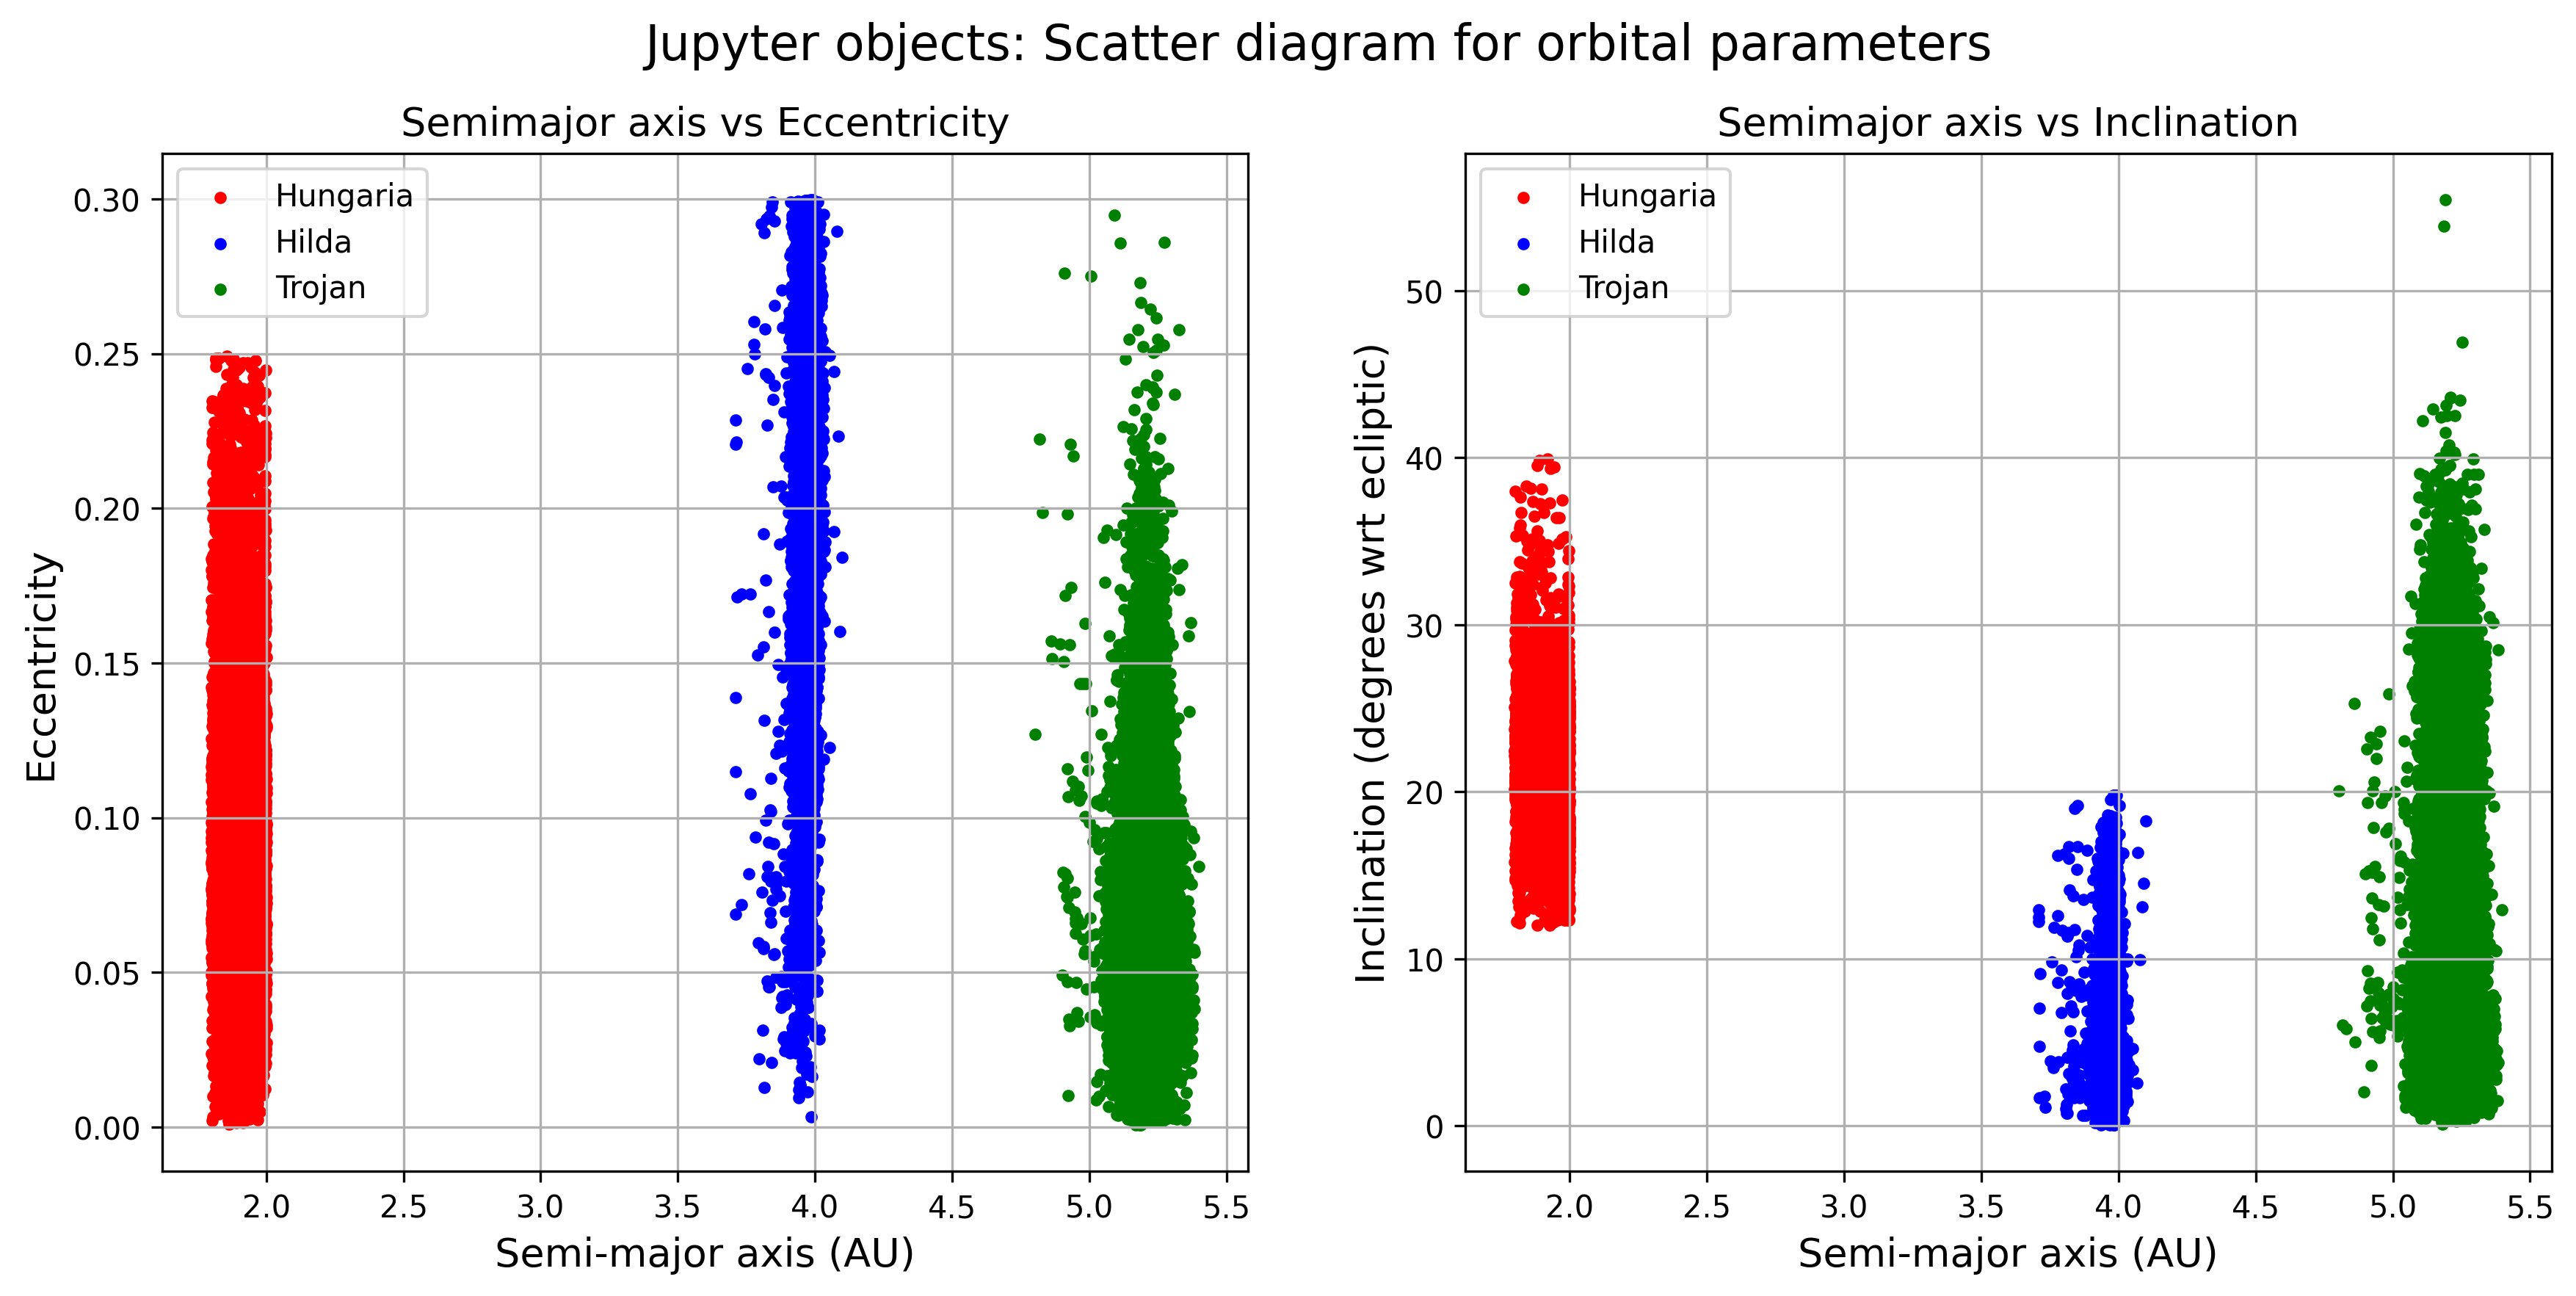

In [13]:
import matplotlib.pyplot as plt
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

fig.suptitle('Jupyter objects: Scatter diagram for orbital parameters', fontsize=16)

MPC_Jupyter_Hungaria_a = MPC_Jupyter_no_outliers.apply(lambda r: r[MPC_Jupyter_no_outliers['Orbit_type'].isin(['Hungaria'])])['a']
MPC_Jupyter_Hilda_a = MPC_Jupyter_no_outliers.apply(lambda r: r[MPC_Jupyter_no_outliers['Orbit_type'].isin(['Hilda'])])['a']
MPC_Jupyter_Trojan_a = MPC_Jupyter_no_outliers.apply(lambda r: r[MPC_Jupyter_no_outliers['Orbit_type'].isin(['Trojan'])])['a']

MPC_Jupyter_Hungaria_e = MPC_Jupyter_no_outliers.apply(lambda r: r[MPC_Jupyter_no_outliers['Orbit_type'].isin(['Hungaria'])])['e']
MPC_Jupyter_Hilda_e = MPC_Jupyter_no_outliers.apply(lambda r: r[MPC_Jupyter_no_outliers['Orbit_type'].isin(['Hilda'])])['e']
MPC_Jupyter_Trojan_e = MPC_Jupyter_no_outliers.apply(lambda r: r[MPC_Jupyter_no_outliers['Orbit_type'].isin(['Trojan'])])['e']

MPC_Jupyter_Hungaria_i = MPC_Jupyter_no_outliers.apply(lambda r: r[MPC_Jupyter_no_outliers['Orbit_type'].isin(['Hungaria'])])['i']
MPC_Jupyter_Hilda_i = MPC_Jupyter_no_outliers.apply(lambda r: r[MPC_Jupyter_no_outliers['Orbit_type'].isin(['Hilda'])])['i']
MPC_Jupyter_Trojan_i = MPC_Jupyter_no_outliers.apply(lambda r: r[MPC_Jupyter_no_outliers['Orbit_type'].isin(['Trojan'])])['i']

ax1.set_title('Semimajor axis vs Eccentricity', fontsize=13)
x = ax1.scatter(MPC_Jupyter_Hungaria_a, MPC_Jupyter_Hungaria_e, color='r', marker=".", label="Hungaria")
y = ax1.scatter(MPC_Jupyter_Hilda_a, MPC_Jupyter_Hilda_e, color='b', marker=".", label="Hilda")
z = ax1.scatter(MPC_Jupyter_Trojan_a, MPC_Jupyter_Trojan_e, color='g', marker=".", label="Trojan")
ax1.set_xlabel("Semi-major axis (AU)", fontsize=13)
ax1.set_ylabel("Eccentricity", fontsize=13)
ax1.legend()
ax1.grid()

ax2.set_title('Semimajor axis vs Inclination', fontsize=13)
x_2 = ax2.scatter(MPC_Jupyter_Hungaria_a, MPC_Jupyter_Hungaria_i, color='r', marker=".", label="Hungaria")
y_2 = ax2.scatter(MPC_Jupyter_Hilda_a, MPC_Jupyter_Hilda_i, color='b', marker=".", label="Hilda")
z_2 = ax2.scatter(MPC_Jupyter_Trojan_a, MPC_Jupyter_Trojan_i, color='g', marker=".", label="Trojan")
ax2.set_xlabel("Semi-major axis (AU)", fontsize=13)
ax2.set_ylabel("Inclination (degrees wrt ecliptic)", fontsize=13)
ax2.legend()
ax2.grid()

fig.savefig('figure/jupyter_objects_semi_major_axis.png', dpi=600)

### Distribution of absolute magnitude (H) per types

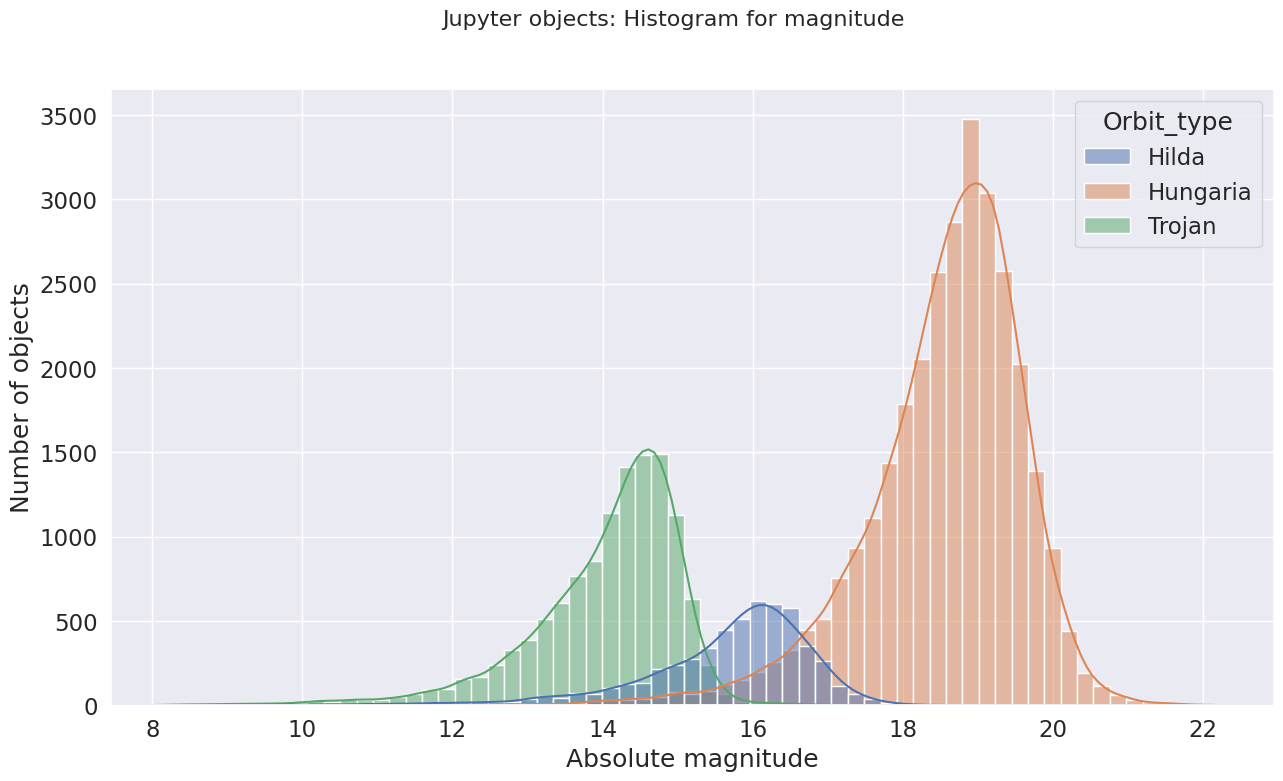

In [15]:
import matplotlib.pyplot as plt
sns.set_theme()
sns.set(font_scale=1.5)  
plt.figure(figsize=(15,8))
p = sns.histplot(data=MPC_Jupyter_no_outliers, x="H", kde=True, hue="Orbit_type")
p.set(xlabel="Absolute magnitude", ylabel = "Number of objects")
plt.xlim([MPC_Jupyter_no_outliers.H.min(), MPC_Jupyter_no_outliers.H.max()])
plt.suptitle('Jupyter objects: Histogram for magnitude', fontsize=16)

plt.savefig("figure/jupyter_objects_absolute_magnitude.png", dpi=600)

## Hilda objects

In [16]:
MPC_Jupyter_no_outliers_Hilda = MPC_Jupyter_no_outliers[MPC_Jupyter_no_outliers['Orbit_type'] =='Hilda']
MPC_Jupyter_no_outliers_Hilda.head(5)

,H,G,Num_obs,rms,Arc_years,Name,Principal_desig,Other_desigs,Epoch,M,Peri,Node,i,e,a,Last_obs,Orbital_period,q,Q,Semilatus_rectum,Synodic_period,Orbit_type
152,7.67,0.15,3868.0,0.60,1880-2022,Hilda,A875 VC,['1935 GD'],2459800.5,323.99445,39.40652,228.08895,7.82771,0.139723,3.975533,2022-09-09,7.926711,3.420061,4.531004,1.948960,1.144369,Hilda
189,7.71,0.15,3598.0,0.59,1894-2022,Ismene,A878 SA,"['1947 QJ', '1951 DB']",2459800.5,47.82330,271.08085,175.43821,6.17637,0.167797,3.992202,2022-05-05,7.976617,3.322323,4.662081,1.939899,1.143336,Hilda
333,7.74,0.15,3895.0,0.60,1892-2022,Chicago,A892 QB,['A903 HA'],2459800.5,29.15827,152.02831,130.17120,4.64299,0.024570,3.890742,2022-10-18,7.674474,3.795147,3.986337,1.944197,1.149825,Hilda
360,8.46,0.15,3186.0,0.56,1893-2022,Bononia,A893 EF,"['1953 VD2', '1975 LJ']",2459800.5,244.86853,68.20164,18.78966,12.61286,0.210557,3.966830,2022-10-18,7.900696,3.131586,4.802074,1.895482,1.144913,Hilda
498,9.48,0.15,3901.0,0.60,1902-2022,Venusia,A902 YE,['1950 CE'],2459800.5,59.68919,174.86060,256.22624,2.09148,0.217132,4.012093,2022-06-12,8.036308,3.140941,4.883246,1.911469,1.142120,Hilda


### Filter on top 120 Hilda objects

In [17]:
n_hilda_object = 120
object_list_tot = MPC_Jupyter_no_outliers_Hilda.set_index('Principal_desig').to_dict()['Name']
object_list = {key: value for (key, value) in object_list_tot.items() if not str(value) == 'nan'}
object_list = {A:N for (A,N) in [x for x in object_list.items()][:n_hilda_object]}
main_body = {"Sun" : 'Sun', "Jupiter" : 'Jupiter'}
object_list = {**main_body, **object_list}

In [18]:
list(object_list.items())[:120]

[('Sun', 'Sun'),
 ('Jupiter', 'Jupiter'),
 ('A875 VC', 'Hilda'),
 ('A878 SA', 'Ismene'),
 ('A892 QB', 'Chicago'),
 ('A893 EF', 'Bononia'),
 ('A902 YE', 'Venusia'),
 ('A913 EL', 'Simeisa'),
 ('A921 SD', 'Asplinda'),
 ('A924 WO', 'Tuckia'),
 ('1930 BJ', 'Oda'),
 ('1930 AC', 'Larissa'),
 ('1931 GE', 'Rita'),
 ('1931 RL', 'Marina'),
 ('1931 XC', 'Francette'),
 ('1932 PD', 'Normannia'),
 ('1930 HJ', 'Libya'),
 ('1930 SH', 'Rollandia'),
 ('A908 CE', 'Potomac'),
 ('1937 TE', 'Vogtia'),
 ('1939 FE', 'Oulu'),
 ('1938 BC', 'Oterma'),
 ('1951 AT', 'Kirkwood'),
 ('1963 RF', 'Brouwer'),
 ('1966 RA', 'Mauderli'),
 ('1935 FE', 'Cunningham'),
 ('1971 FC', 'Marsden'),
 ('1972 HU', 'Shaposhnikov'),
 ('1973 UD', 'Schubart'),
 ('1931 TN1', 'Wild'),
 ('1936 DD', 'Aksnes'),
 ('1979 XH', 'Bowell'),
 ('1976 GU2', 'Duboshin'),
 ('1928 QB', 'Guinevere'),
 ('1962 RE', 'Samitchell'),
 ('1980 TU6', 'Kacha'),
 ('1983 RE2', 'Scholl'),
 ('A921 VA', 'Kostinsky'),
 ('A908 AA', 'Graff'),
 ('1982 UM', 'Bus'),
 ('1973 SZ1

### Plot current orbit snapshot

In [30]:
import numpy as np
import rebound
import datetime

sim = rebound.Simulation()
sim.units = ['mearth','day','AU']

print(f"*** G: {sim.G}") 

index_obj = 0
missing_mass = []
for jupiter_object, jupiter_name in object_list.items():
    sim.add(jupiter_object)
    #if sim.particles[index_obj].m == 0:
    #    sim.remove(index_obj)
    #    missing_mass.append(jupiter_object)
    #    #index_obj = index_obj - 1
    #else:
    print(f"*** Mass of object: {jupiter_name} {sim.particles[index_obj].m} Radius: {sim.particles[index_obj].r}")
    index_obj = index_obj + 1

current_time = datetime.datetime.now()
print("*** Current timestamp is:", current_time)

for i in missing_mass:
    object_list.pop(i)

sim.move_to_com()
#sim.integrator = "ias15"

Jupiter_period = 4330 # Jupiter period
N_output = 433 # number of sample 

# each point is 10 Earth days

x_pos = np.zeros((len(object_list), N_output)) 
y_pos = np.zeros((len(object_list), N_output))
z_pos = np.zeros((len(object_list), N_output))

print(f"*** step: {sim.dt}") 

times = np.linspace(0, Jupiter_period, num = N_output) 

object_index = 0
for jupiter_object, jupiter_name in object_list.items():
    print (f"Integration for object number: {object_index} name: {jupiter_name}")
    for position, t in enumerate (times):
        sim.integrate(t)
        x_pos[object_index, position] = sim.particles[object_index].x
        y_pos[object_index, position] = sim.particles[object_index].y
        z_pos[object_index, position] = sim.particles[object_index].z
    object_index = object_index + 1

*** G: 8.887692445125634e-10
Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
*** Mass of object: Sun 332946.0488322924 Radius: 0.0
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
*** Mass of object: Jupiter 317.8941938720353 Radius: 0.0
Searching NASA Horizons for 'A875 VC'... 
Found: 153 Hilda (A875 VC) 
*** Mass of object: Hilda 0.0 Radius: 0.0
Searching NASA Horizons for 'A878 SA'... 
Found: 190 Ismene (A878 SA) 
*** Mass of object: Ismene 0.0 Radius: 0.0
Searching NASA Horizons for 'A892 QB'... 
Found: 334 Chicago (A892 QB) 
*** Mass of object: Chicago 0.0 Radius: 0.0
Searching NASA Horizons for 'A893 EF'... 
Found: 361 Bononia (A893 EF) 
*** Mass of object: Bononia 0.0 Radius: 0.0
Searching NASA Horizons for 'A902 YE'... 
Found: 499 Venusia (A902 YE) 
*** Mass of object: Venusia 0.0 Radius: 0.0
Searching NASA Horizons for 'A913 EL'... 
Found: 748 Simeisa (A913 EL) 
*** Mass of object: Simeisa 0.0 Radius: 0.0
Searching NA

Found: 7174 Semois (1988 SQ) 
*** Mass of object: Semois 0.0 Radius: 0.0
Searching NASA Horizons for '1985 QX4'... 
Found: 7394 Xanthomalitia (1985 QX4) 
*** Mass of object: Xanthomalitia 0.0 Radius: 0.0
Searching NASA Horizons for '1989 RB6'... 
Found: 8086 Peterthomas (1989 RB6) 
*** Mass of object: Peterthomas 0.0 Radius: 0.0
Searching NASA Horizons for '1976 DJ1'... 
Found: 8130 Seeberg (1976 DJ1) 
*** Mass of object: Seeberg 0.0 Radius: 0.0
Searching NASA Horizons for '1994 PV24'... 
Found: 8550 Hesiodos (1994 PV24) 
*** Mass of object: Hesiodos 0.0 Radius: 0.0
Searching NASA Horizons for '1994 VC7'... 
Found: 8551 Daitarabochi (1994 VC7) 
*** Mass of object: Daitarabochi 0.0 Radius: 0.0
Searching NASA Horizons for '1996 AO3'... 
Found: 8721 AMOS (1996 AO3) 
*** Mass of object: AMOS 0.0 Radius: 0.0
Searching NASA Horizons for '1998 EH12'... 
Found: 8743 Keneke (1998 EH12) 
*** Mass of object: Keneke 0.0 Radius: 0.0
Searching NASA Horizons for '1995 YK3'... 
Found: 8915 Sawaishujir

Integration for object number: 34 name: Samitchell
Integration for object number: 35 name: Kacha
Integration for object number: 36 name: Scholl
Integration for object number: 37 name: Kostinsky
Integration for object number: 38 name: Graff
Integration for object number: 39 name: Bus
Integration for object number: 40 name: Azabu
Integration for object number: 41 name: Danby
Integration for object number: 42 name: Hooke
Integration for object number: 43 name: Sokolsky
Integration for object number: 44 name: Devine
Integration for object number: 45 name: Milanstefanik
Integration for object number: 46 name: Putilin
Integration for object number: 47 name: Eupraksia
Integration for object number: 48 name: Sharon
Integration for object number: 49 name: OISCA
Integration for object number: 50 name: Radzievskij
Integration for object number: 51 name: Heimdal
Integration for object number: 52 name: Shuya
Integration for object number: 53 name: van den Bergh
Integration for object number: 54 nam

### Save status

In [31]:
sim.simulationarchive_snapshot(f"bin/hilda_simulation_{n_hilda_object}.bin", deletefile=True)
#sim = rebound.Simulation(f"/data/workspace_files/bin/hilda_simulation_{n_hilda_object}.bin")

### Plot them !!

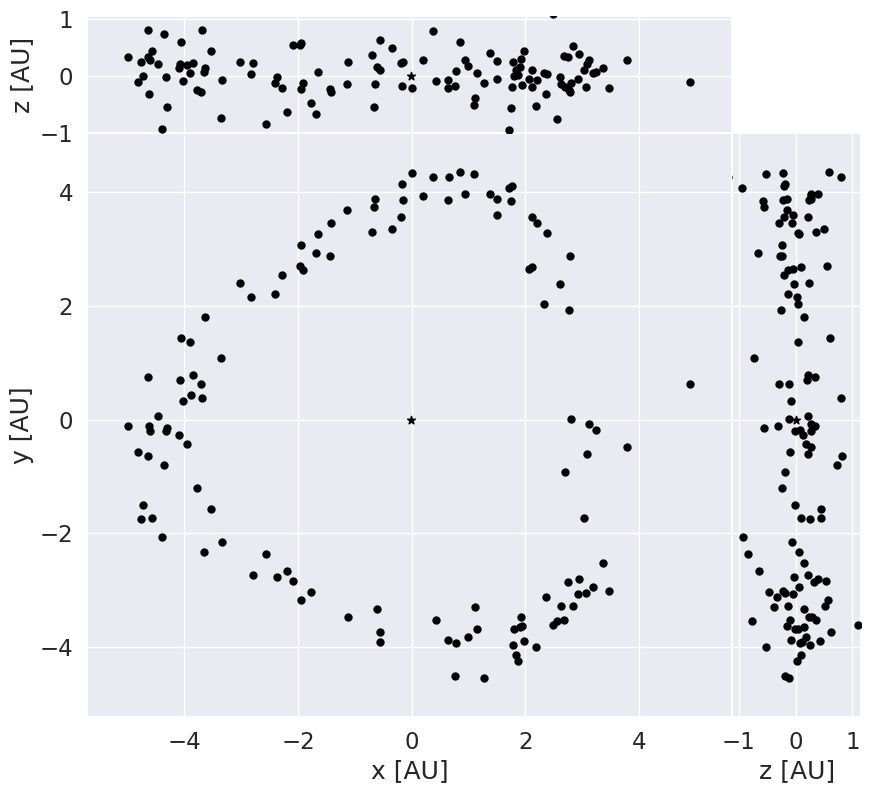

In [32]:
import matplotlib.pyplot as plt
current_time = datetime.datetime.now()
timestamp_str = "Hilda objects at localtime: " + str(current_time)
fig = rebound.OrbitPlot(sim, figsize=(10,10), unitlabel="[AU]", color=True, slices=0.2, orbit_type=None, lw=1)
plt.savefig("figure/hilda_objects_orbit_2d.png", dpi=600)

### Objects Orbit for one Jupiter year

Preparing diagram # [0, 0]
Preparing diagram # [0, 1]
Preparing diagram # [0, 2]
Preparing diagram # [1, 0]
Preparing diagram # [1, 1]
Preparing diagram # [1, 2]
Preparing diagram # [2, 0]
Preparing diagram # [2, 1]
Preparing diagram # [2, 2]
Preparing diagram # [3, 0]
Preparing diagram # [3, 1]


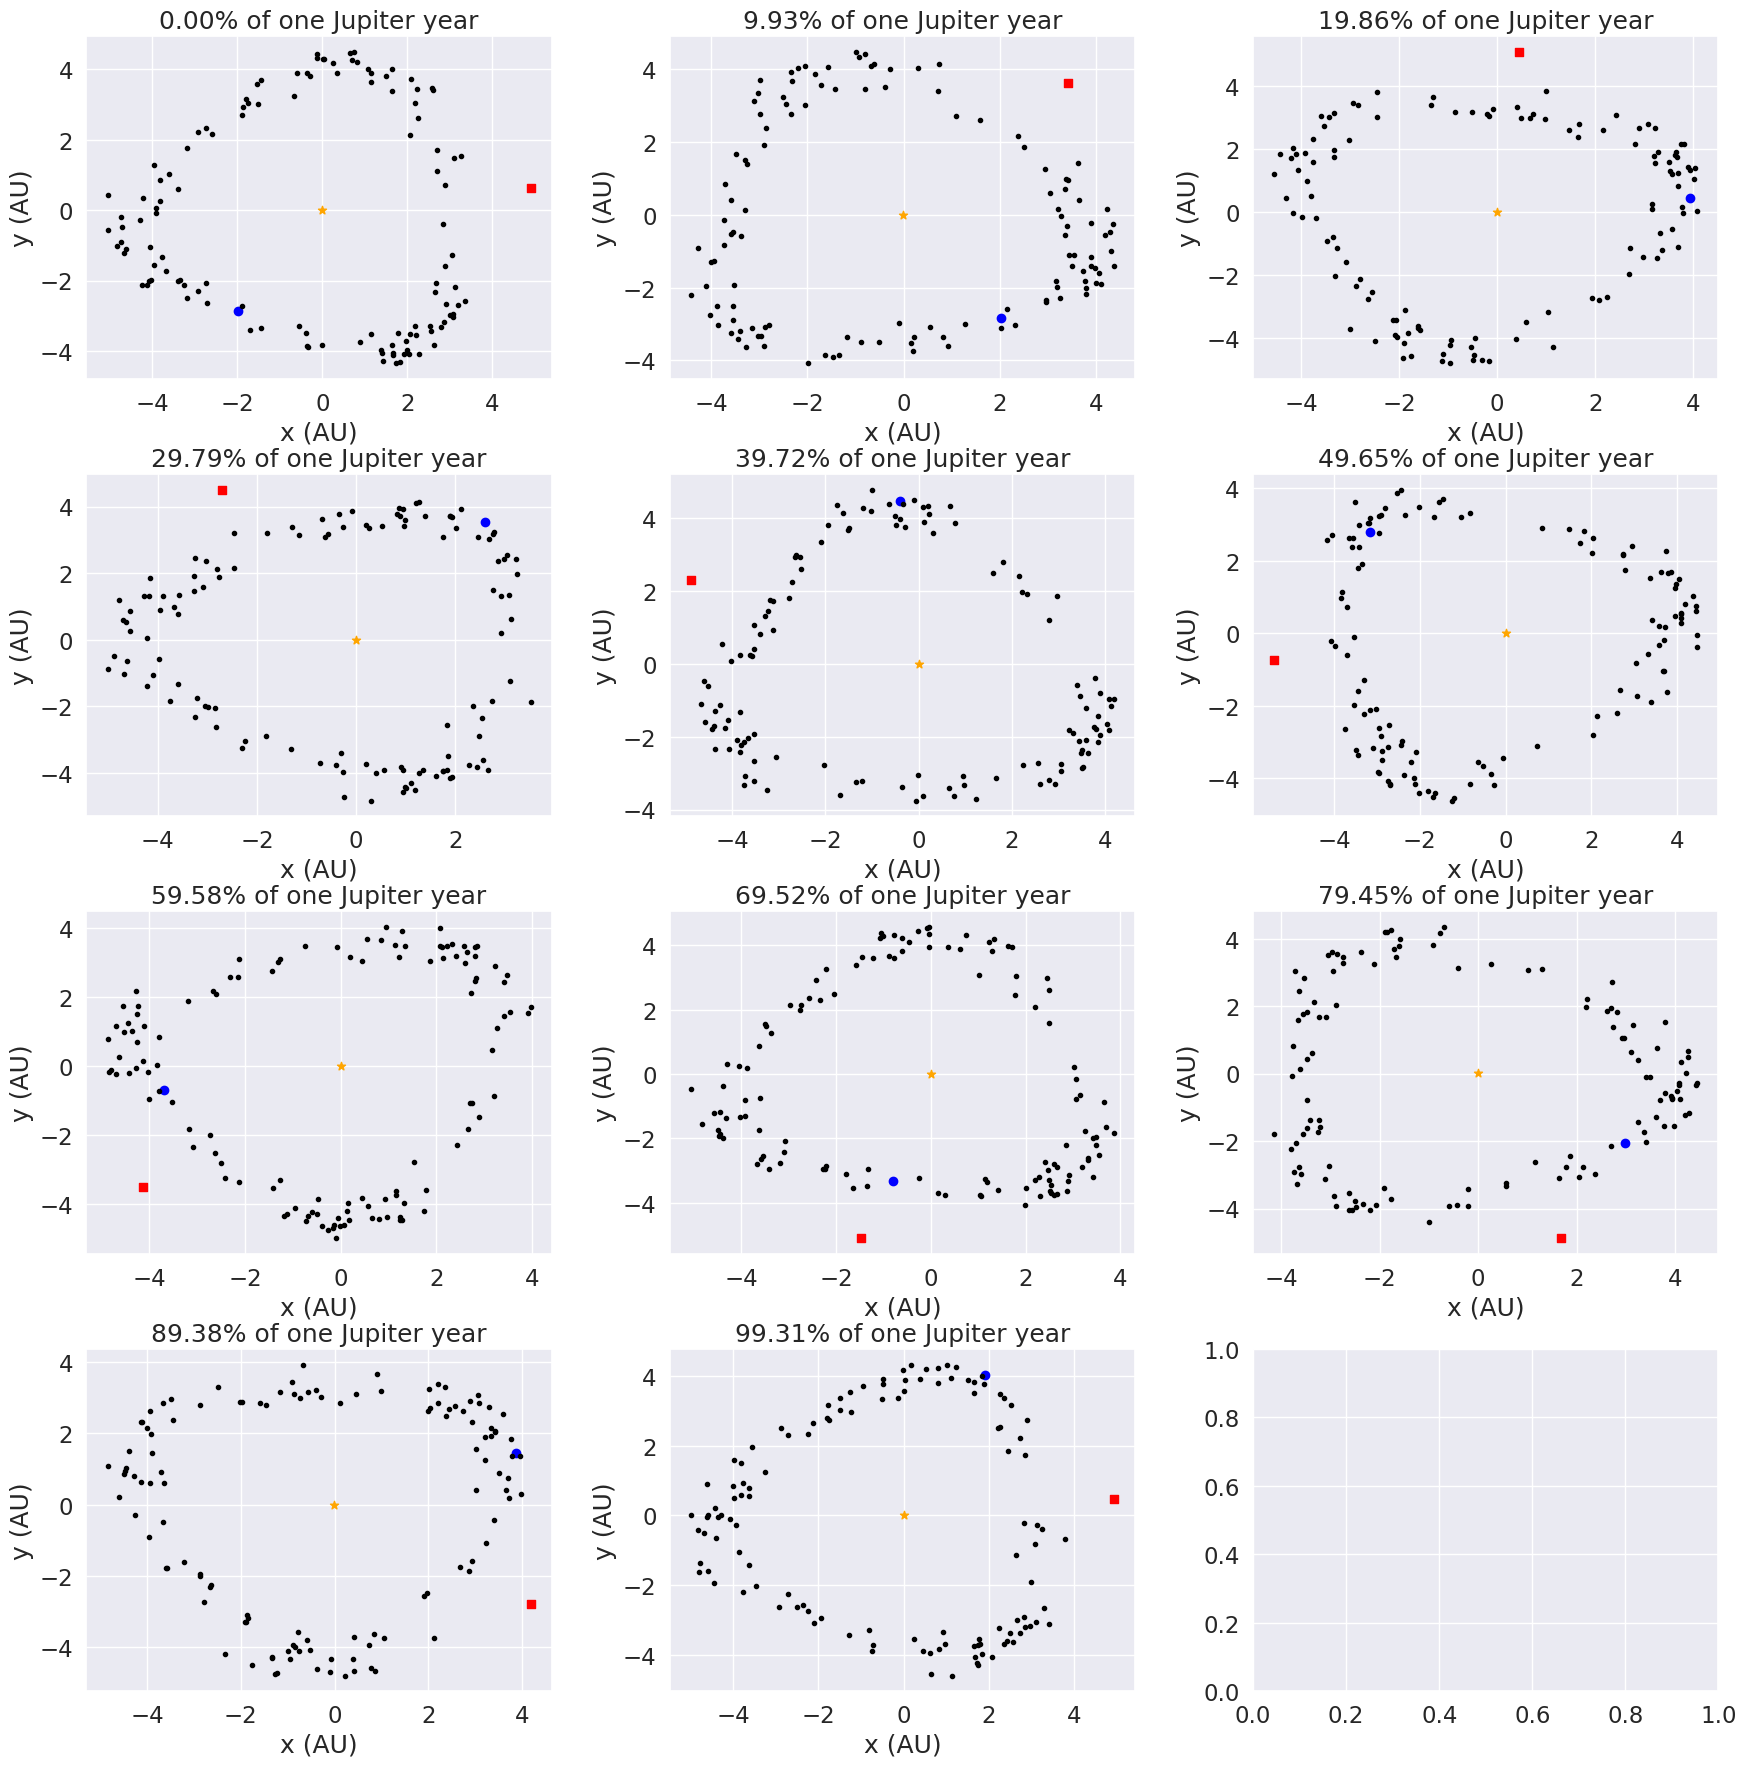

In [33]:
import matplotlib.pyplot as plt

n_row = 4
n_col = 3

fig_hilda, axs = plt.subplots(n_row, n_col, figsize=(18, 18))

row = 0
Jupiter_period = 4330 # Jupiter period
N_output = 433 # number of sample 

fig_hilda.tight_layout(pad = 2.0)

time_tick = 0
for sample in range(0, (n_col * n_row) - 1):
    col = sample % n_col
    print (f"Preparing diagram # [{row}, {col}]")
    for obj in range(0, object_index):
        if obj == 0:
            axs[row, col].scatter(x_pos[obj, time_tick], y_pos[obj, time_tick], c= 'orange', marker="*")
        else:
            if obj == 1:
                axs[row, col].scatter(x_pos[obj, time_tick], y_pos[obj, time_tick], c= 'red', marker="s")
            else:
                if obj == 2:
                    axs[row, col].scatter(x_pos[obj, time_tick], y_pos[obj, time_tick], c= 'blue', marker="o")
                else:
                    axs[row, col].scatter(x_pos[obj, time_tick], y_pos[obj, time_tick], c= 'black', marker=".")
        axs[row, col].grid()
    axs[row, col].set_title(f"{time_tick/N_output * 100:.2f}% of one Jupiter year")
    axs[row, col].set_xlabel("x (AU)")
    axs[row, col].set_ylabel("y (AU)")
    time_tick = time_tick + int(N_output / 10)
    if col == (n_col - 1):
        row = row + 1

plt.savefig("figure/hilda_objects_orbit_frames.png", dpi=600)

### Plot some of them in 3D

Preparing diagram # [0, 0]
Preparing diagram # [0, 1]
Preparing diagram # [1, 0]
Preparing diagram # [1, 1]


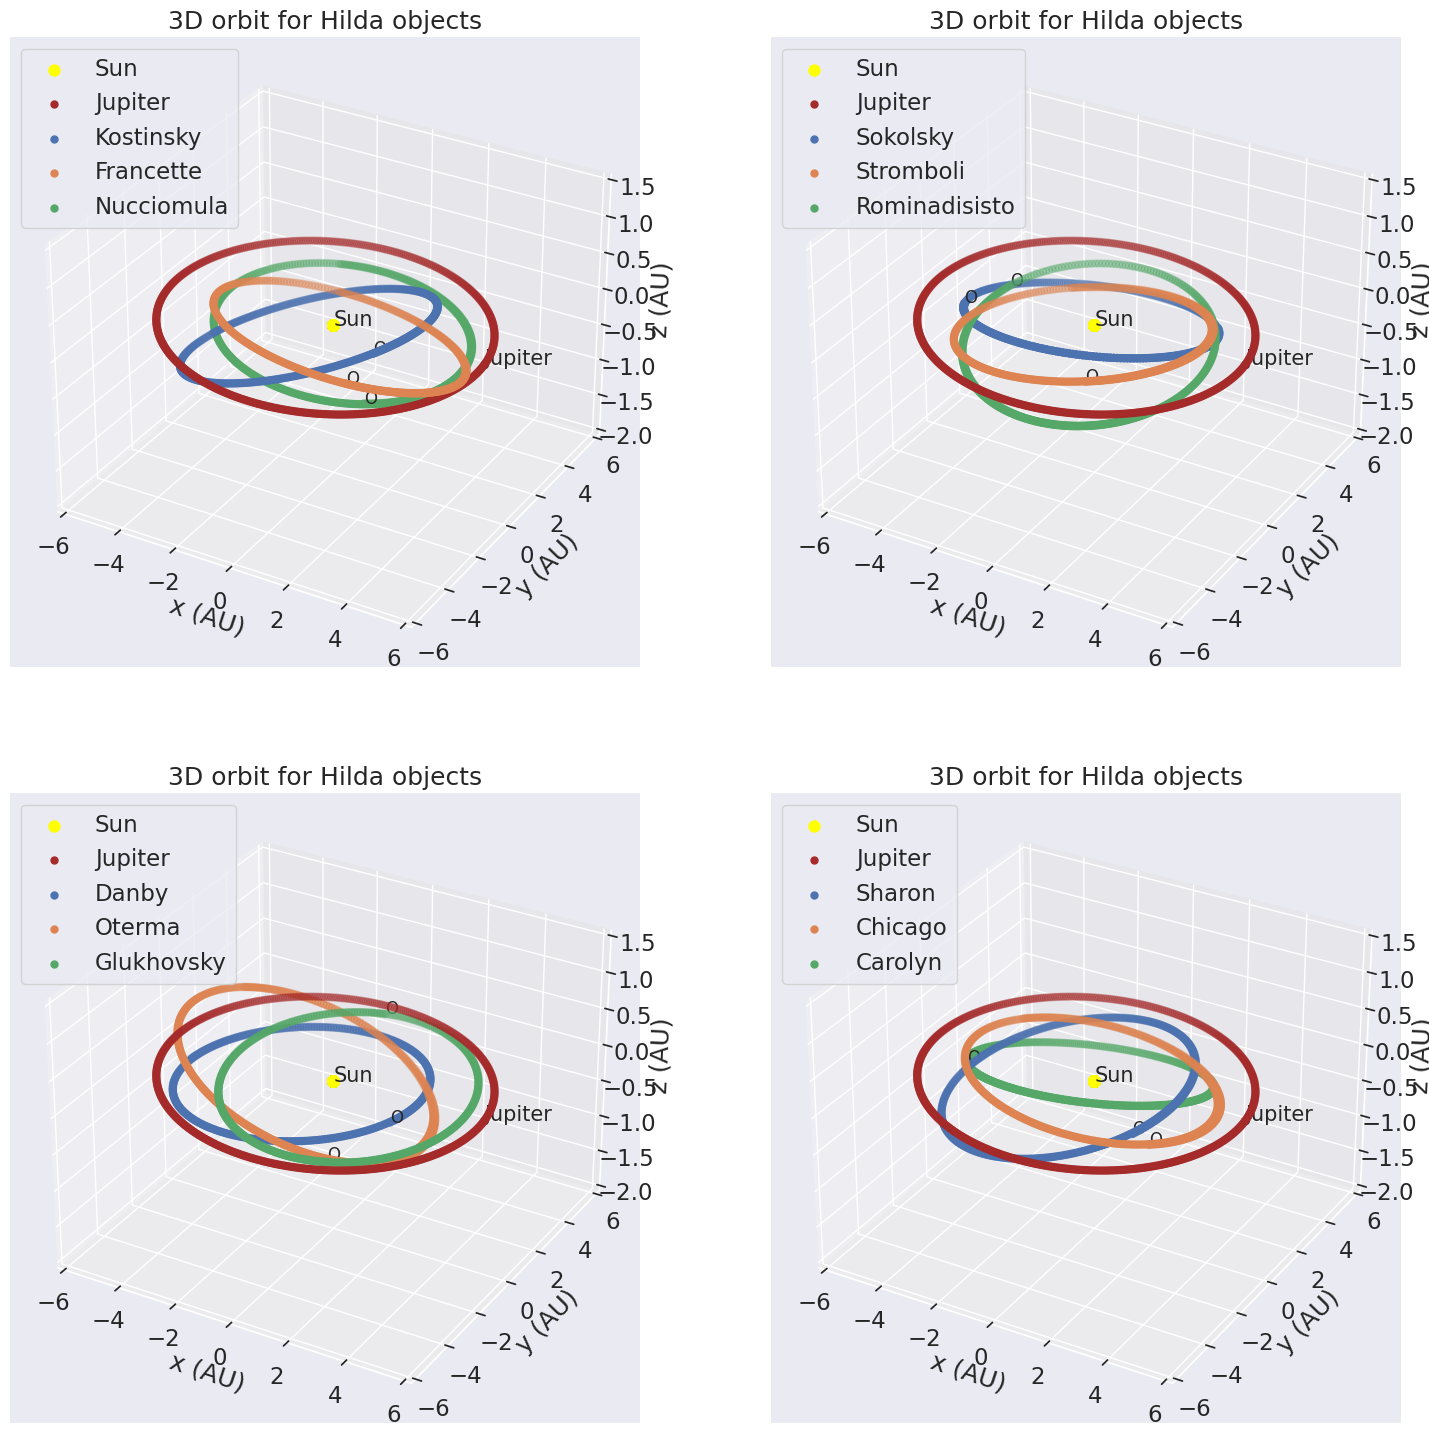

In [35]:
%matplotlib inline

import matplotlib.pyplot as plt

n_row = 2
n_col = 2
limit_x = 6

fig_hilda_3d = plt.figure(figsize=(18, 18))
fig_hilda_3d.tight_layout(pad = 2.0)

object_slice_list = list(object_list.values())
row = 0
num_plot = 1

for sample in range(0, (n_col * n_row)):
    col = sample % n_col
    print (f"Preparing diagram # [{row}, {col}]")
    axs = fig_hilda_3d.add_subplot(n_row, n_col, num_plot, projection='3d')
    
    axs.scatter3D(x_pos[0], y_pos[0], z_pos[0], marker='.', color='yellow', s=250)
    axs.text(x_pos[0][0], y_pos[0][0], z_pos[0][0], 'Sun', size=15)
    
    axs.scatter3D(x_pos[1], y_pos[1], z_pos[1], marker='.', color='Brown', s=100)
    axs.text(x_pos[1][0], y_pos[1][0], z_pos[1][0], 'Jupiter', size=15)
    
    leg_list = ['Sun', 'Jupiter']
    random_object_index = np.random.randint(2, object_index, size=3)
    for obj in random_object_index:
        axs.scatter3D(x_pos[obj], y_pos[obj], z_pos[obj], marker='.', s=100)
        axs.text(x_pos[obj][0], y_pos[obj][0], z_pos[obj][0], 'O', size=12)
        leg_list.append(object_slice_list[obj])
    axs.grid()
    axs.set_xlabel('x (AU)')
    axs.set_ylabel('y (AU)')
    axs.set_zlabel('z (AU)')
    axs.set_xlim(-limit_x, limit_x)
    axs.set_ylim(-limit_x, limit_x)
    axs.set_zlim(-2, 1.5)
    axs.legend(leg_list, loc='upper left')

    axs.set_title(f"3D orbit for Hilda objects")
    if col == (n_col - 1):
        row = row + 1
    num_plot = num_plot + 1

plt.savefig("figure/hilda_objects_orbit_random_3d.png", dpi=600)

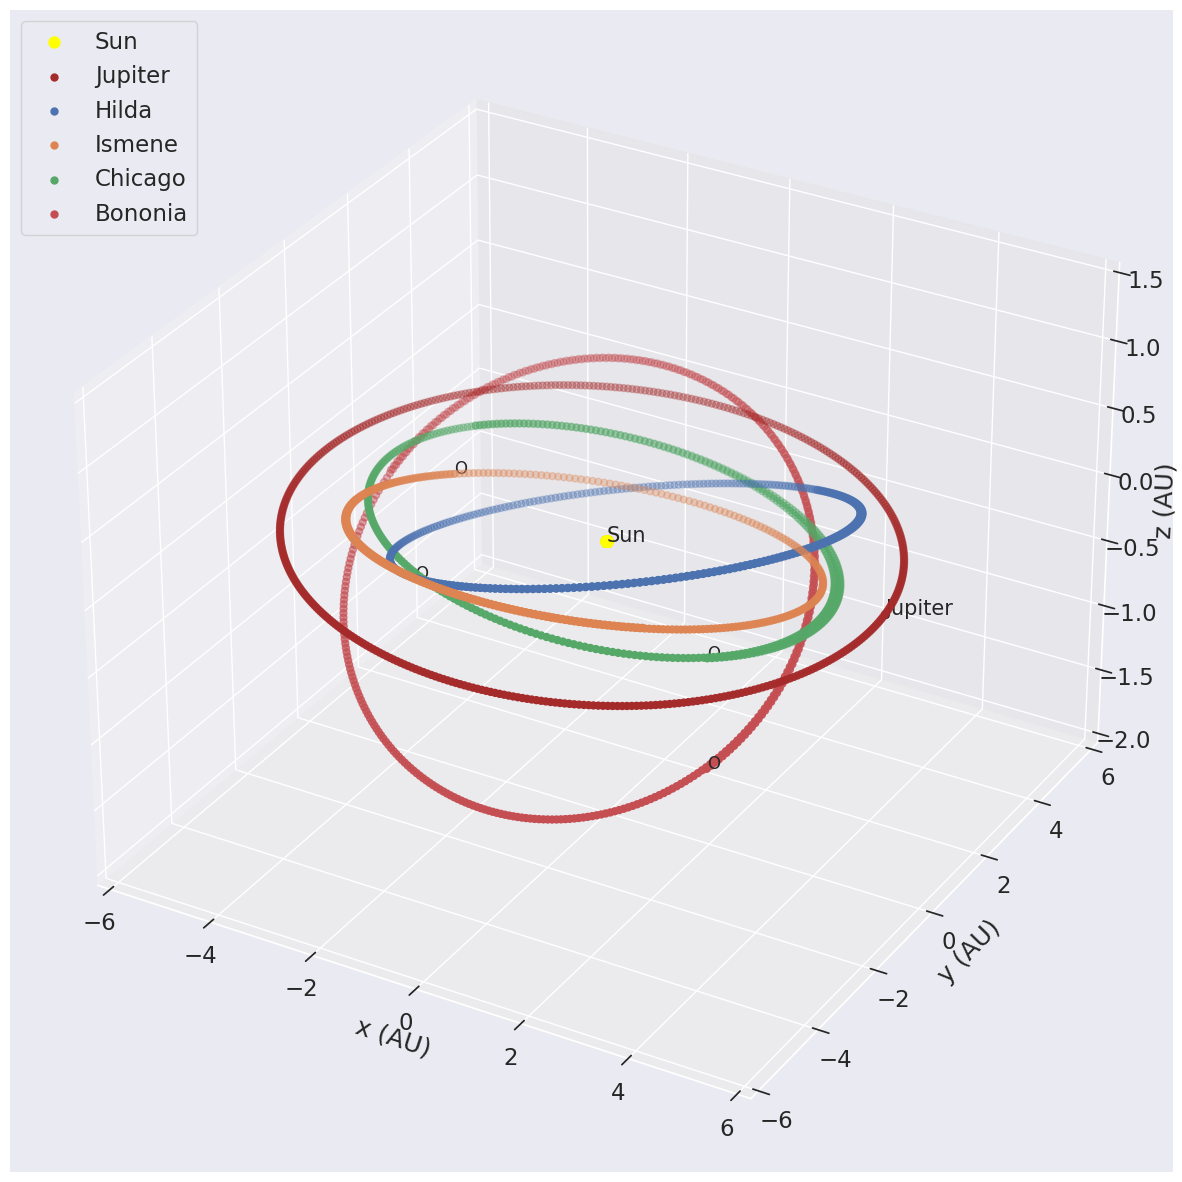

In [36]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 35))

ax = plt.axes(projection='3d')

ax.scatter3D(x_pos[0], y_pos[0], z_pos[0], marker='.', color='yellow', s=250)
ax.text(x_pos[0][0], y_pos[0][0], z_pos[0][0], 'Sun', size=15)

ax.scatter3D(x_pos[1], y_pos[1], z_pos[1], marker='.', color='Brown', s=100)
ax.text(x_pos[1][0], y_pos[1][0], z_pos[1][0], 'Jupiter', size=15)

object_index = 0
for jupiter_object, jupiter_name in object_list.items():
    if (object_index == 0) or (object_index == 1):
        object_index = object_index + 1
        continue
    ax.scatter3D(x_pos[object_index], y_pos[object_index], z_pos[object_index], marker='.', s=100)
    ax.text(x_pos[object_index][0], y_pos[object_index][0], z_pos[object_index][0], 'O', size=12)
    if object_index == 5:
        break
    object_index = object_index + 1

ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')
ax.set_zlabel('z (AU)')
limit_x = 6
ax.set_xlim(-limit_x, limit_x); ax.set_ylim(-limit_x, limit_x); ax.set_zlim(-2, 1.5)
ax.legend(object_list.values(), loc='upper left')

plt.savefig("figure/hilda_objects_orbit_3d.png", dpi=600)

### Resonance between Hilda objects and Jupiter

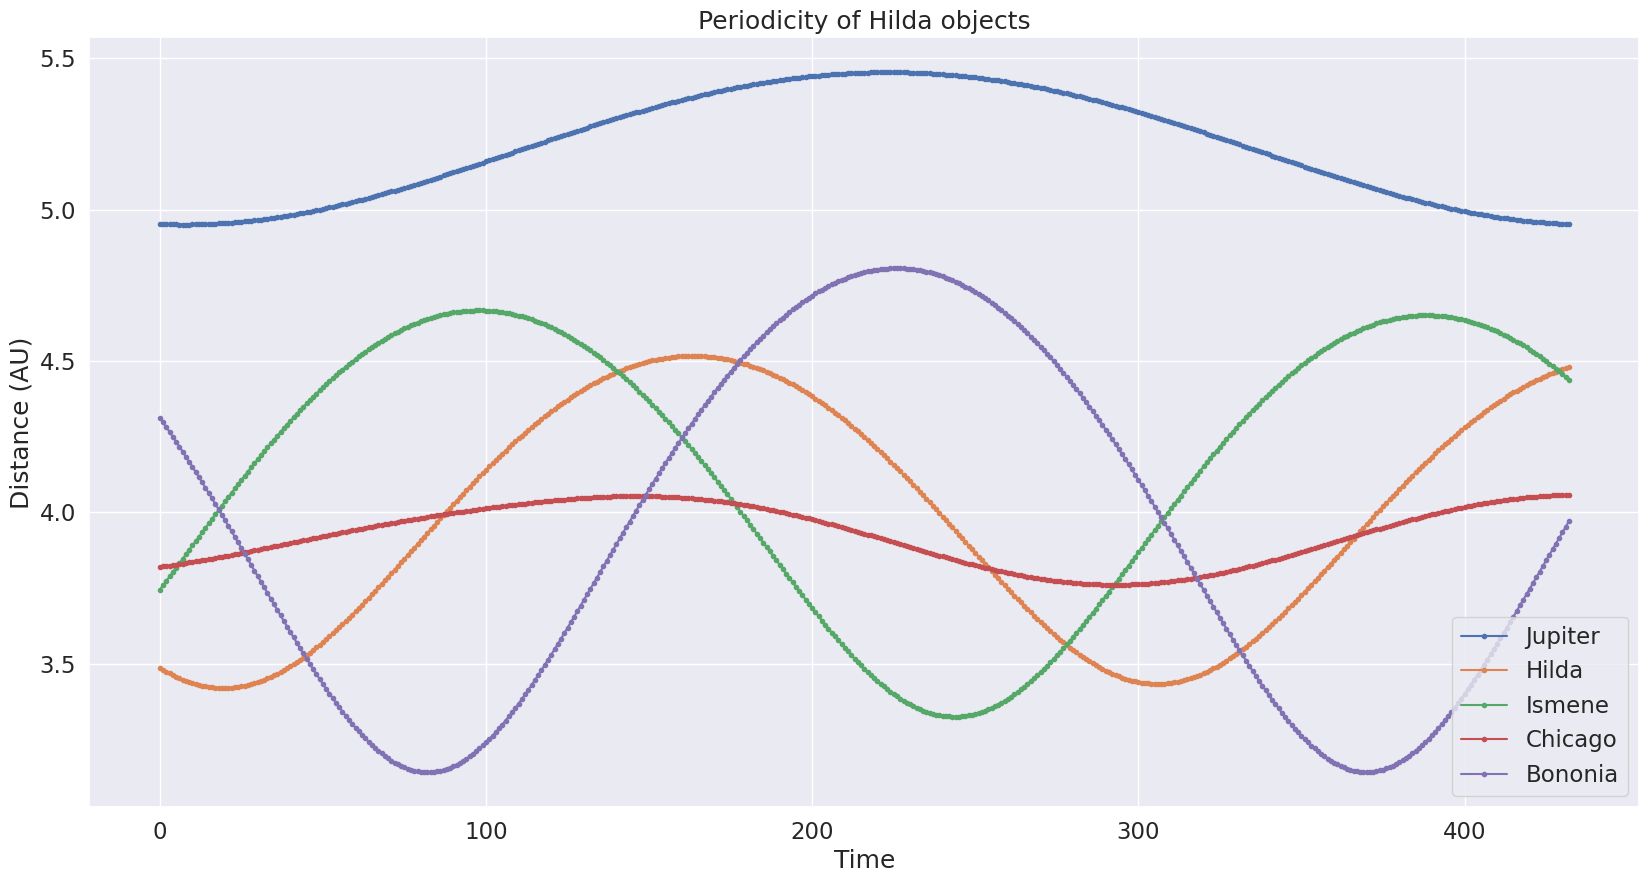

In [37]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))

object_index = 0
distance = {}
for jupiter_object, jupiter_name in object_list.items():
    if object_index == 0:
        object_index = object_index + 1
        continue
    distance [jupiter_name] = np.zeros((1, N_output)) 
    distance [jupiter_name] = np.sqrt(np.square(x_pos[0]-x_pos[object_index]) + np.square(y_pos[0]-y_pos[object_index]) + np.square(z_pos[0]-z_pos[object_index]))
    object_index = object_index + 1
    plt.plot(distance [jupiter_name], label = jupiter_name, marker=".")
    plt.grid()
    if object_index > 5:
        break

plt.grid()
plt.title ('Periodicity of Hilda objects')
plt.xlabel("Time")
plt.ylabel("Distance (AU)")
plt.legend()

plt.savefig("figure/hilda_objects_resonance.png", dpi=600)

### Save DF

In [39]:
MPC_Jupyter_no_outliers_Hilda.to_pickle("bin/df_hilda.pkl")

In [2]:
MPC_Jupyter_no_outliers_Hilda = pd.read_pickle("bin/df_hilda.pkl")

### Estimate mass of objects
- (formula) http://www.physics.sfasu.edu/astro/asteroids/sizemagnitude.html
- (table) https://www.minorplanetcenter.net/iau/Sizes.html 
- (formula) https://cneos.jpl.nasa.gov/tools/ast_size_est.html

In [40]:
MPC_Jupyter_no_outliers_Hilda.head(5)

,H,G,Num_obs,rms,Arc_years,Name,Principal_desig,Other_desigs,Epoch,M,Peri,Node,i,e,a,Last_obs,Orbital_period,q,Q,Semilatus_rectum,Synodic_period,Orbit_type
152,7.67,0.15,3868.0,0.60,1880-2022,Hilda,A875 VC,['1935 GD'],2459800.5,323.99445,39.40652,228.08895,7.82771,0.139723,3.975533,2022-09-09,7.926711,3.420061,4.531004,1.948960,1.144369,Hilda
189,7.71,0.15,3598.0,0.59,1894-2022,Ismene,A878 SA,"['1947 QJ', '1951 DB']",2459800.5,47.82330,271.08085,175.43821,6.17637,0.167797,3.992202,2022-05-05,7.976617,3.322323,4.662081,1.939899,1.143336,Hilda
333,7.74,0.15,3895.0,0.60,1892-2022,Chicago,A892 QB,['A903 HA'],2459800.5,29.15827,152.02831,130.17120,4.64299,0.024570,3.890742,2022-10-18,7.674474,3.795147,3.986337,1.944197,1.149825,Hilda
360,8.46,0.15,3186.0,0.56,1893-2022,Bononia,A893 EF,"['1953 VD2', '1975 LJ']",2459800.5,244.86853,68.20164,18.78966,12.61286,0.210557,3.966830,2022-10-18,7.900696,3.131586,4.802074,1.895482,1.144913,Hilda
498,9.48,0.15,3901.0,0.60,1902-2022,Venusia,A902 YE,['1950 CE'],2459800.5,59.68919,174.86060,256.22624,2.09148,0.217132,4.012093,2022-06-12,8.036308,3.140941,4.883246,1.911469,1.142120,Hilda


### Diameter vs albedo data for Hilda objects

- Read data from  https://sbn.psi.edu/pds/resource/neowisediam.html and preprocess them

In [68]:
colspecs = ((0, 6), (7, 22), (24, 28), (30, 34), (36, 40), (42, 47),)
names  = ('Asteroid_number', 'Prov_design','2','3','4','Diameter')

iras_df = pd.read_fwf('data/iras_hildas.csv', colspecs=colspecs, header=None, names=names)
iras_df.drop(['2','3','4'], axis=1, inplace=True)

iras_df.head(60)

,Asteroid_number,Prov_design,Diameter
0,1,Ceres,910.0
1,2,Pallas,521.0
2,3,Juno,243.0
3,4,Vesta,500.0
4,5,Astraea,124.0
5,6,Hebe,191.0
6,7,Iris,202.0
7,8,Flora,141.0
8,9,Metis,737.0
9,10,Hygiea,427.0


In [44]:
neo_wise_df = pd.read_csv("data/neowise_hildas.csv")
neo_wise_df.drop(['Slope_param','Mean_JD','N_W1','N_W2','N_W3', 'N_W4','Fit_code','IR_albedo','IR_albedo_err','Beaming_param','Beaming_param_err','Stacked_flag','Reference','Notes'], axis=1, inplace=True)
neo_wise_df['MPC_packed_name'] = neo_wise_df['MPC_packed_name'].str.strip()
neo_wise_df['Prov_design'] = neo_wise_df['Prov_design'].str.strip()
#neo_wise_df = neo_wise_df.apply(lambda r: r[~neo_wise_df['Prov_design'].isin(['-'])])
neo_wise_df.head(10)

,Asteroid_number,Prov_design,MPC_packed_name,Absolute_mag,Diameter,Diameter_err,V_albedo,V_albedo_err
0,153,-,00153,7.48,218.844,7.001,0.038,0.007
1,190,-,00190,7.59,214.664,7.295,0.035,0.006
2,334,-,00334,7.60,198.770,5.597,0.041,0.007
3,361,-,00361,8.22,154.334,5.413,0.038,0.005
4,499,-,00499,9.39,77.328,1.055,0.052,0.008
5,748,-,00748,9.01,103.714,1.128,0.041,0.007
6,958,-,00958,10.71,45.112,0.405,0.045,0.008
7,1144,-,01144,9.90,56.337,0.501,0.061,0.012
8,1162,-,01162,9.44,42.243,0.404,0.169,0.031
9,1162,-,01162,9.44,40.379,0.301,0.186,0.037


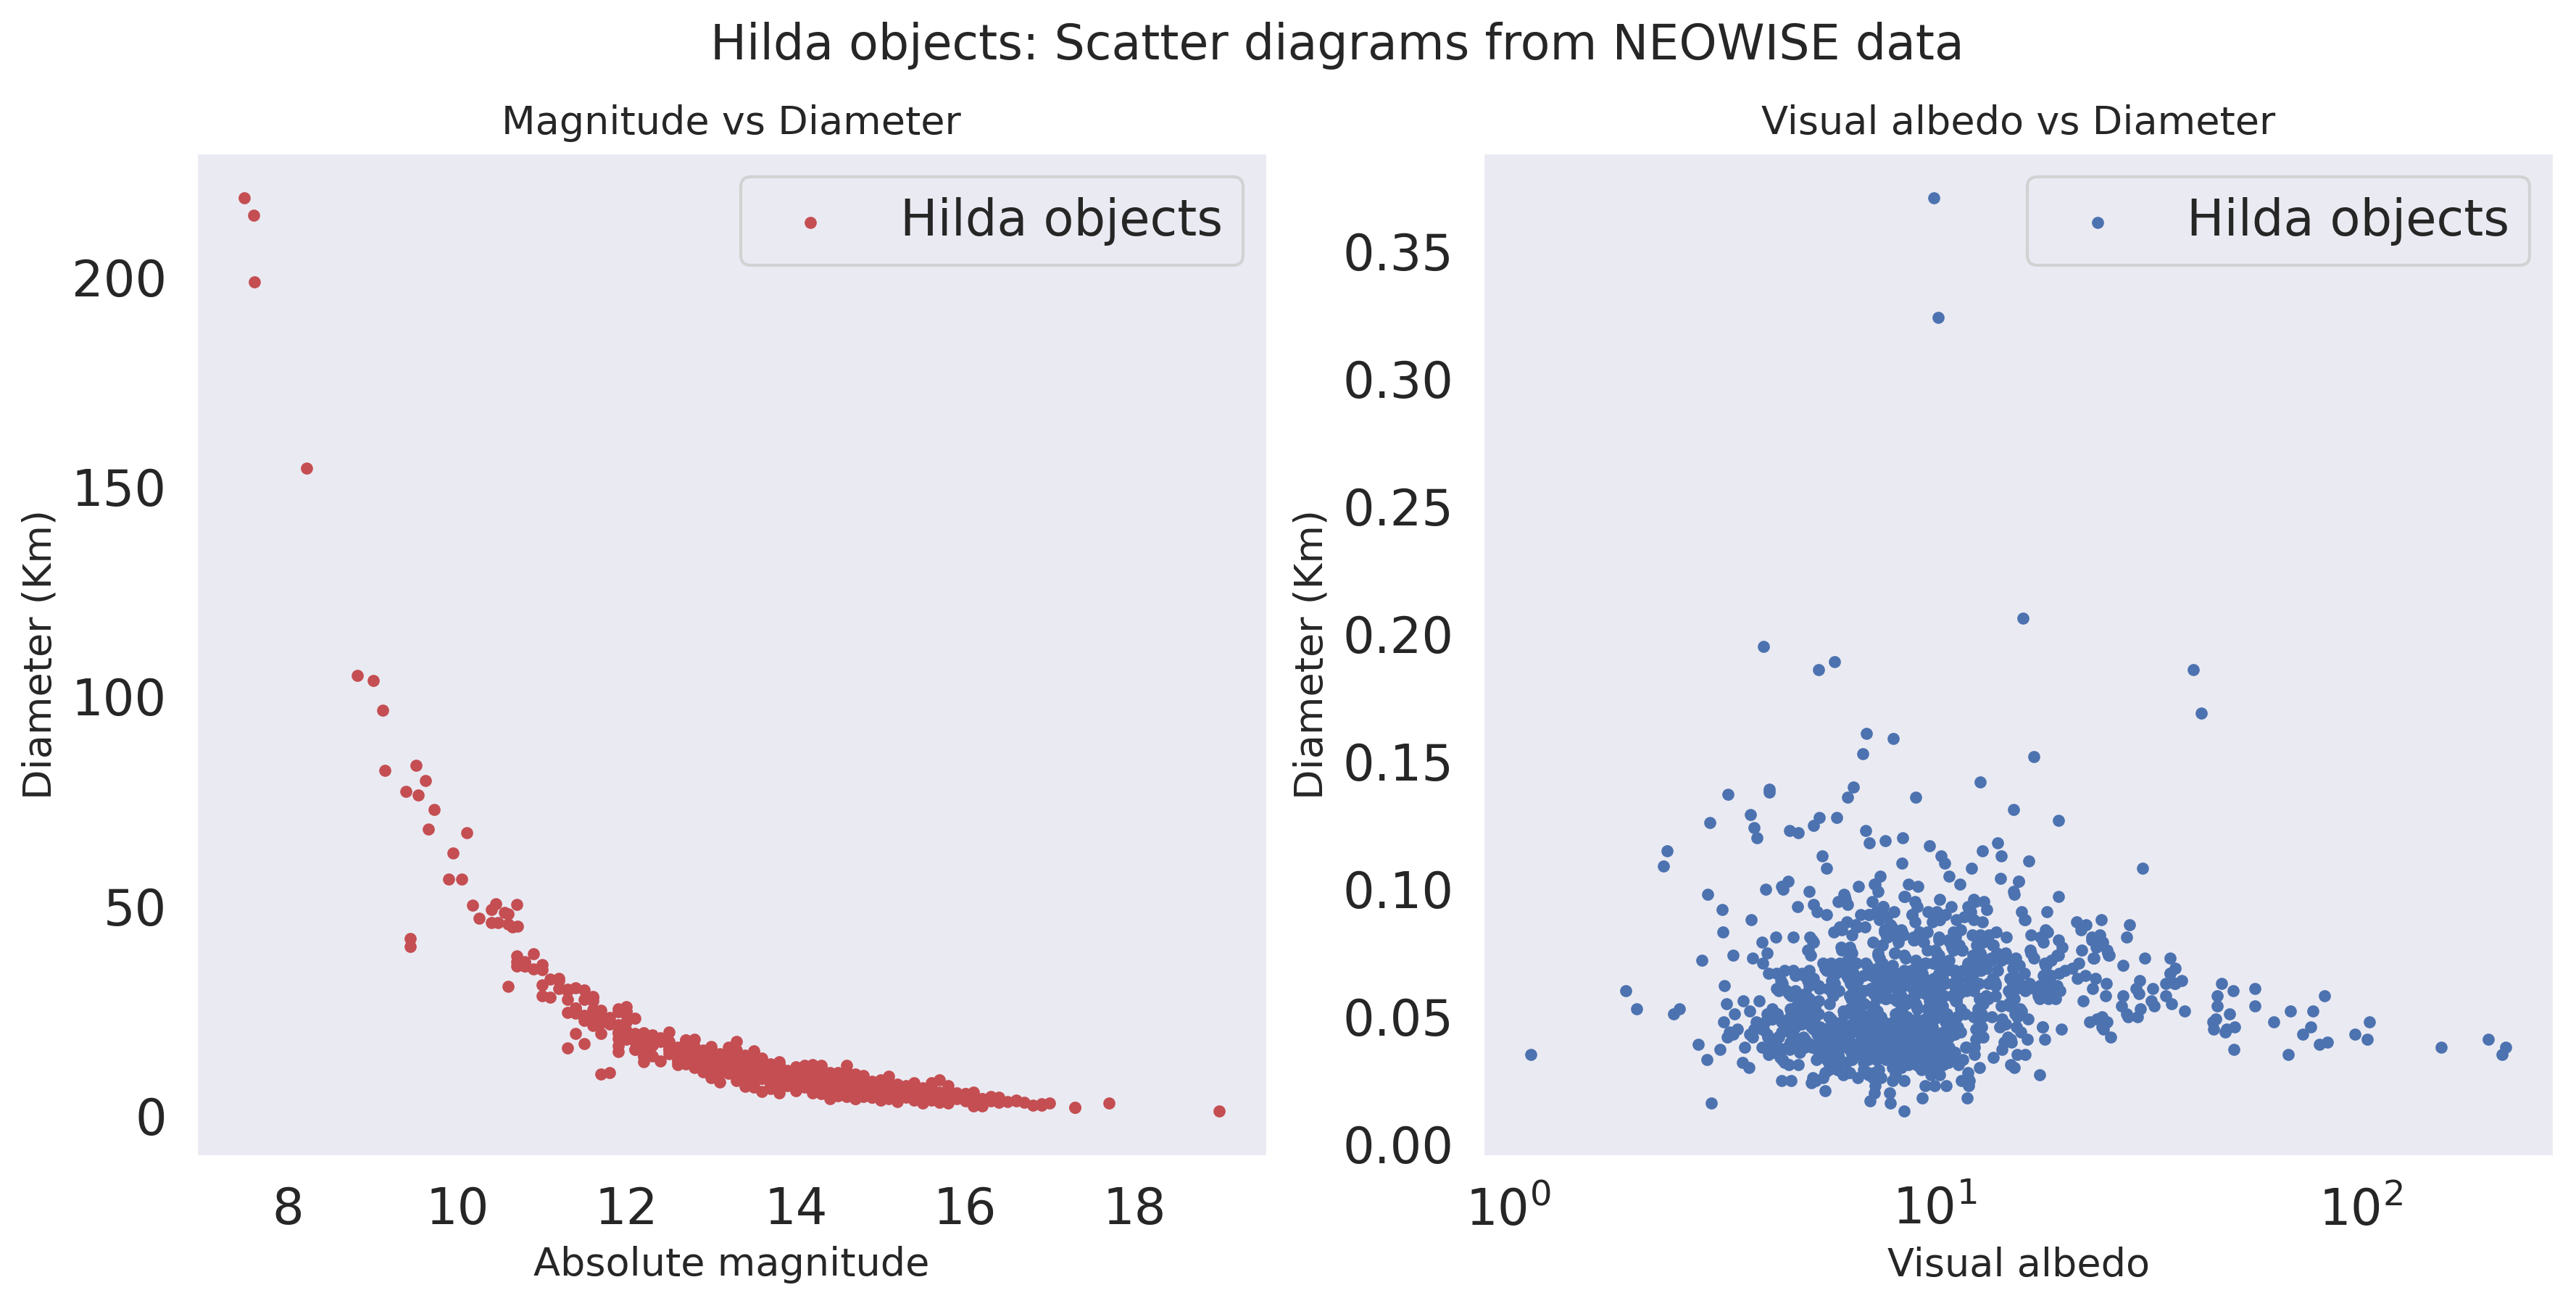

In [47]:
import matplotlib.pyplot as plt
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

fig.suptitle('Hilda objects: Scatter diagrams from NEOWISE data', fontsize=16)

ax1.set_title('Magnitude vs Diameter', fontsize=13)
x = ax1.scatter(neo_wise_df ['Absolute_mag'], neo_wise_df ['Diameter'], color='r', marker=".", label="Hilda objects")
ax1.set_xlabel("Absolute magnitude", fontsize=13)
ax1.set_ylabel("Diameter (Km)", fontsize=13)
ax1.legend()
ax1.grid()

ax2.set_title('Visual albedo vs Diameter', fontsize=13)
ax2.set_xscale('log')
y = ax2.scatter(neo_wise_df ['Diameter'], neo_wise_df ['V_albedo'], color='b', marker=".", label="Hilda objects")
ax2.grid()
ax2.set_xlabel("Visual albedo", fontsize=13)
ax2.set_ylabel("Diameter (Km)", fontsize=13)
ax2.legend()

fig.savefig('figure/hilda_objects_magnitude_albedo_diameter.png', dpi=600)

In [52]:
import folium
from geopy.geocoders import Nominatim

locator = Nominatim(user_agent='myGeocoder')
location = locator.geocode('Via Bestetti 8, Villasanta')

color = [ "red", "blue", "green", "yellow", "purple", 'black', 'white','orange']

stat = pd.DataFrame({'Stat': neo_wise_df['Diameter'].describe(), 'color': color, 'gav_lat': location.latitude, 'gav_lon': location.longitude})
stat = stat.drop('count')
stat = stat.drop('std')

m = folium.Map(location=(stat['gav_lat'].mean(), stat['gav_lon'].mean()), zoom_start=8, title="Object size", Stamen='Toner')

for lat, lon, diam, color in zip(stat['gav_lat'], 
                                 stat['gav_lon'], 
                                 stat['Stat'], 
                                 stat['color']):
    radius = int(diam * 1000 / 2)    
    label = folium.Popup('Hilda object diameter: ' + str(diam) + " Km", parse_html=True)
    folium.Circle(location = (lat, lon),
                  popup = label,
                  radius = radius,
                  color = color,
                  fill=True,
                  fill_opacity=0.1).add_to(m)

m.save('figure/hilda_objects_size_on_terrain_folium.html')
m

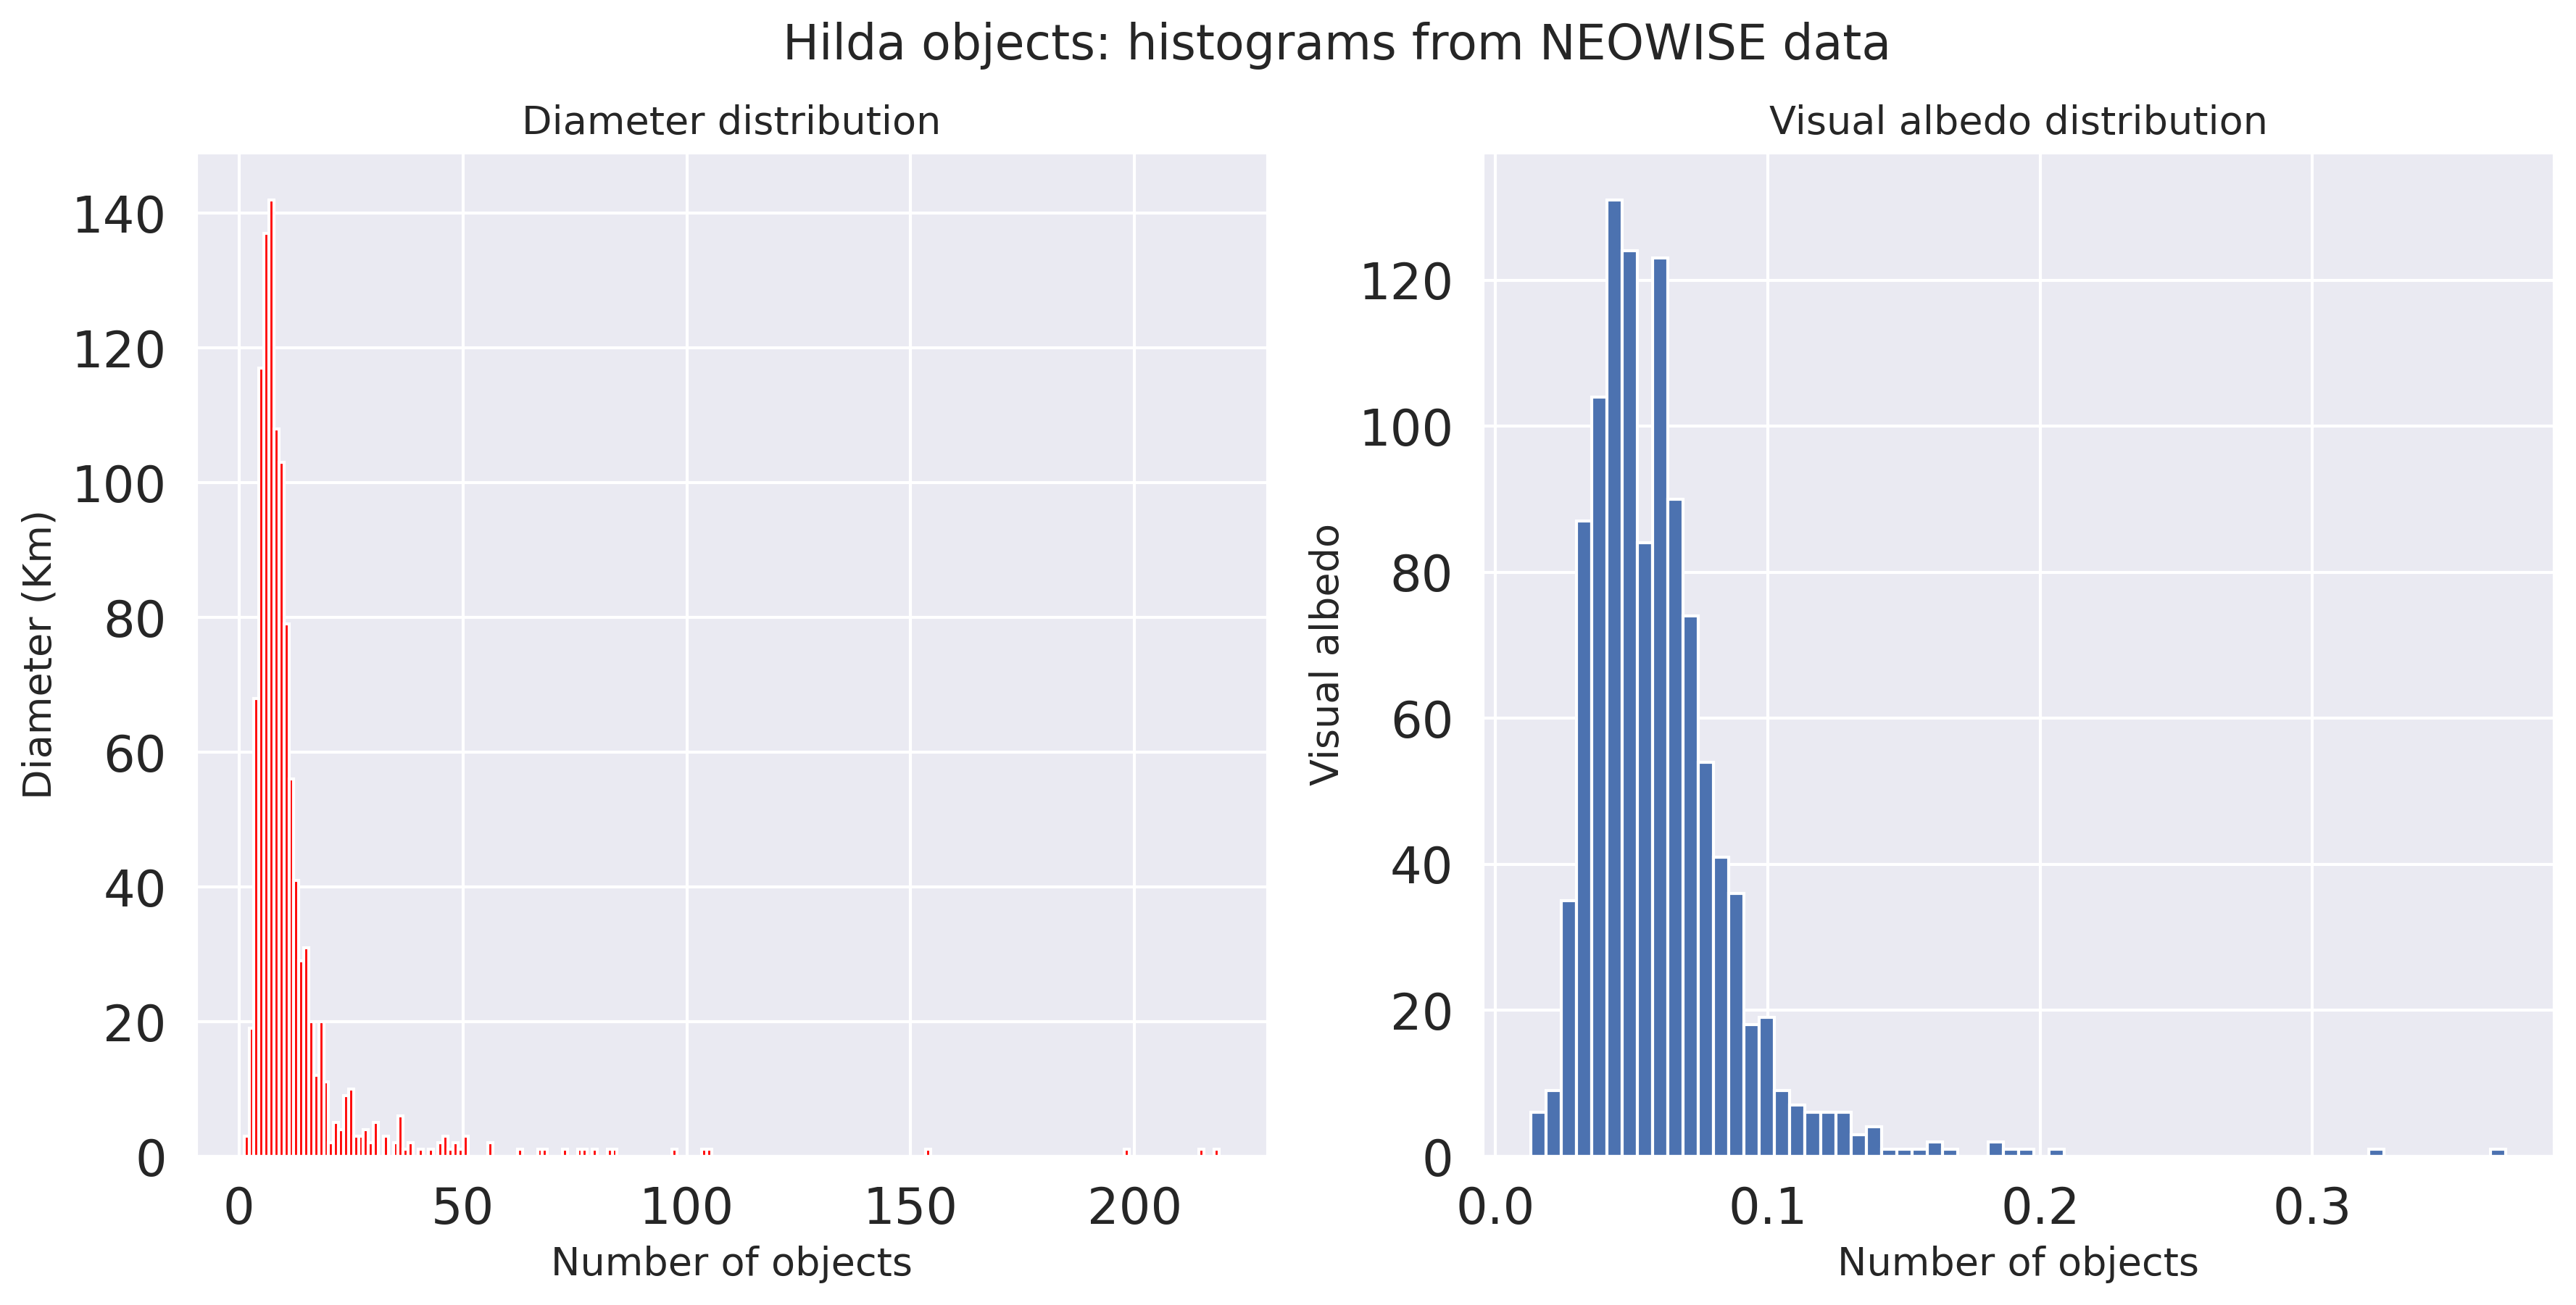

In [54]:
import matplotlib.pyplot as plt
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

fig.suptitle('Hilda objects: histograms from NEOWISE data', fontsize=16)

ax1.set_title('Diameter distribution', fontsize=13)
ax1.hist(neo_wise_df['Diameter'], bins='auto', color='red')
ax1.grid()
ax1.set_xlabel("Number of objects", fontsize=13)
ax1.set_ylabel("Diameter (Km)", fontsize=13)
ax1.grid()

ax2.set_title('Visual albedo distribution', fontsize=13)
ax2.hist(neo_wise_df['V_albedo'], bins='auto')
ax2.grid()
ax2.set_xlabel("Number of objects", fontsize=13)
ax2.set_ylabel("Visual albedo", fontsize=13)
ax2.grid()

plt.savefig("figure/hilda_objects_albedo.png", dpi=600)

In [20]:
neo_wise_join_mpc_data = pd.merge(neo_wise_df_fil, MPC_Jupyter_no_outliers_Hilda,left_on='Prov_design',right_on='Principal_desig')
neo_wise_join_mpc_data.head()

,Asteroid_number,Prov_design,MPC_packed_name,Absolute_mag,Slope_param,Mean_JD,N_W1,N_W2,N_W3,N_W4,...,i,e,a,Last_obs,Orbital_period,q,Q,Semilatus_rectum,Synodic_period,Orbit_type
0,7284,1989 VW,07284,11.5,0.15,2.455284e+06,0,0,3,7,...,6.36268,0.166515,3.978343,2022-10-14,7.935118,3.315890,4.640796,1.934017,1.144194,Hilda
1,7458,1984 DE1,07458,11.9,0.15,2.455392e+06,0,0,14,14,...,1.76624,0.172187,3.731025,2022-10-02,7.206797,3.088590,4.373461,1.810203,1.161114,Hilda
2,8376,1992 OZ9,08376,11.5,0.15,2.455210e+06,0,0,11,11,...,3.50955,0.198017,3.987539,2022-07-18,7.962646,3.197940,4.777138,1.915593,1.143624,Hilda
3,8913,1995 YB2,08913,12.5,0.15,2.455204e+06,0,0,6,5,...,1.85936,0.128574,3.957705,2022-09-12,7.873450,3.448848,4.466561,1.946140,1.145487,Hilda
4,10610,1996 XR1,10610,12.1,0.15,2.455331e+06,13,17,17,17,...,4.63162,0.219491,3.961390,2022-05-25,7.884450,3.091901,4.830878,1.885273,1.145255,Hilda


In [3]:
import matplotlib.pyplot as plt
sns.set_theme()
sns.set(font_scale=1.5)  
plt.figure(figsize=(15,8))
p = sns.histplot(data=neo_wise_join_mpc_data, x="Diameter", kde=True)
p.set(xlabel="Diameter (Km)", ylabel = "Number of objects")
plt.xlim([neo_wise_join_mpc_data.Diameter.min(), neo_wise_join_mpc_data.Diameter.max()])
plt.suptitle('Jupyter object: Hilda histogram for diameters', fontsize=16)

plt.savefig("figure/jupyter_hilda_object_diameter.png", dpi=600)

NameError: NameError: name 'neo_wise_join_mpc_data' is not defined

<Figure size 1080x576 with 0 Axes>

In [39]:
import numpy
MPC_Jupyter_no_outliers_Hilda ['d'] = 10 **(3.1236- 0.5 * numpy.log10(MPC_Jupyter_no_outliers_Hilda['a']) - 0.2 * MPC_Jupyter_no_outliers_Hilda ['H'])
MPC_Jupyter_no_outliers_Hilda.to_csv('data/albedo.csv')

## Bibliography

- https://rebound.readthedocs.io/en/latest/ipython_examples/Churyumov-Gerasimenko/
- https://rebound.readthedocs.io/en/latest/ipython_examples/WHFast/
- https://rebound.readthedocs.io/en/latest/integrators/
- https://rebound.readthedocs.io/en/latest/simulationarchive/#reading-simulation-archives
- https://rebound.readthedocs.io/en/latest/ipython_examples/Testparticles/
- https://rebound.readthedocs.io/en/latest/units/
- https://notebook.community/dtamayo/rebound/ipython_examples/OrbitPlot
- https://astroquery.readthedocs.io/en/latest/jplsbdb/jplsbdb.html

In [13]:
import requests
import pprint
# First, define a parameter dictionary
request_dict = {"fields":"full_name,epoch,e,a,q,i,om,w", "sb-class":"COM"}

# Send the query
response = requests.get('https://ssd-api.jpl.nasa.gov/sbdb_query.api', params=request_dict)

# Get the response as a json
json_resp = response.json()
pprint(json_resp)

TypeError: TypeError: 'module' object is not callable

In [85]:
print(json_resp.keys())
print(f"Number of data entries: {json_resp['count']}")

dict_keys(['signature', 'fields', 'data', 'count'])
Number of data entries: 661


In [86]:
objects_df = pd.DataFrame.from_dict(json_resp["data"])
objects_df.columns = json_resp["fields"]
objects_df

,full_name,epoch,e,a,q,i,om,w
0,153P/Ikeya-Zhang,2452402.5,0.9901,51.12,0.507,28.12,93.37,34.67
1,C/1680 V1,2335000.5,1.0000,444.4,0.006,60.68,276.63,350.61
2,C/1769 P1 (Messier),2367454.6,0.9992,163.5,0.123,40.73,178.29,329.12
3,C/1785 E1 (Mechain),2373116.4,0.9965,120.7,0.427,92.64,67.69,127.20
4,C/1807 R1 (Great comet),2381313.7,0.9955,143.2,0.646,63.18,269.48,4.10
...,...,...,...,...,...,...,...,...
656,C/2022 L1 (Catalina),2459797.5,0.9970,528.9,1.591,123.47,300.02,59.85
657,C/2022 L4 (PANSTARRS),2459742.5,0.9881,254.2,3.015,141.22,66.05,125.30
658,C/2022 N1 (Attard-Maury),2459779.5,0.9599,36.93,1.482,164.74,301.86,41.07
659,C/2022 P3 (ZTF),2459831.5,0.9896,246.8,2.561,59.52,72.24,0.09
